In [32]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [33]:
def create_gaussian_kernel():
    """Create the Gaussian kernel h = [1 4 6 4 1]/16"""
    return np.array([1, 4, 6, 4, 1]) / 16.0

def apply_gaussian_filter(image):
    """Apply Gaussian filtering using the specified kernel"""
    kernel = create_gaussian_kernel()
    if len(image.shape) == 3:
        filtered = np.zeros_like(image)
        for i in range(3):
            filtered[:,:,i] = cv2.sepFilter2D(image[:,:,i], -1, kernel, kernel)
        return filtered
    return cv2.sepFilter2D(image, -1, kernel, kernel)

def generate_gaussian_pyramid(image, levels):
    """Generate Gaussian pyramid with L+1 levels"""
    pyramid = [image]
    current = image.copy()
    for _ in range(levels):
        filtered = apply_gaussian_filter(current)
        current = filtered[::2, ::2]
        pyramid.append(current)
    return pyramid

def generate_laplacian_pyramid(image, levels):
    """Generate Laplacian pyramid with L+1 levels"""
    gaussian_pyramid = generate_gaussian_pyramid(image, levels)
    pyramid = []
    
    for i in range(levels):
        current = gaussian_pyramid[i]
        next_level = gaussian_pyramid[i + 1]
        expanded = cv2.resize(next_level, (current.shape[1], current.shape[0]))
        laplacian = current - expanded
        pyramid.append(laplacian)
    
    pyramid.append(gaussian_pyramid[-1])
    return pyramid

def create_eye_mask(shape, center, radius):
    """Create a circular mask for the eye region"""
    mask = np.zeros(shape[:2])
    y, x = np.ogrid[:shape[0], :shape[1]]
    dist_from_center = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask[dist_from_center <= radius] = 1
    
    # Smooth the mask edges
    mask = cv2.GaussianBlur(mask, (21, 21), 10)
    return mask

def blend_pyramids(pyr1, pyr2, mask_pyr):
    """Blend pyramids according to mask"""
    blended_pyr = []
    
    for i in range(len(pyr1)-1):
        mask = np.expand_dims(mask_pyr[i], axis=2) if len(pyr1[i].shape) == 3 else mask_pyr[i]
        blended = mask * pyr1[i] + (1 - mask) * pyr2[i]
        blended_pyr.append(blended)
    
    mask = np.expand_dims(mask_pyr[-1], axis=2) if len(pyr1[-1].shape) == 3 else mask_pyr[-1]
    last_level = mask * pyr1[-1] + (1 - mask) * pyr2[-1]
    blended_pyr.append(last_level)
    
    return blended_pyr

def reconstruct_from_pyramid(pyramid):
    """Reconstruct image from pyramid"""
    current = pyramid[-1]
    
    for level in reversed(pyramid[:-1]):
        expanded = cv2.resize(current, (level.shape[1], level.shape[0]))
        current = expanded + level
    
    return current

In [34]:
# Read images
hand = cv2.imread('photos/hand.png', cv2.IMREAD_GRAYSCALE).astype(float) / 255
face = cv2.imread('photos/woman.png', cv2.IMREAD_GRAYSCALE).astype(float) / 255
    
# Ensure images are the same size
if hand.shape != face.shape:
    face = cv2.resize(face, (hand.shape[1], hand.shape[0]))
    
# Create eye mask - adjust these coordinates based on your images
eye_center = (hand.shape[1]//2, hand.shape[0]//2)  # Center of the image
eye_radius = min(hand.shape) // 6  # Adjust radius as needed
mask = create_eye_mask(hand.shape, eye_center, eye_radius)
    
# Number of pyramid levels
L = 4

In [35]:
# Generate pyramids
mask_pyramid = generate_gaussian_pyramid(mask, L)
hand_pyramid = generate_laplacian_pyramid(hand, L)
face_pyramid = generate_laplacian_pyramid(face, L)
    
# Blend pyramids
blended_pyramid = blend_pyramids(face_pyramid, hand_pyramid, mask_pyramid)
    
# Reconstruct final image
result = reconstruct_from_pyramid(blended_pyramid)
result = np.clip(result, 0, 1)

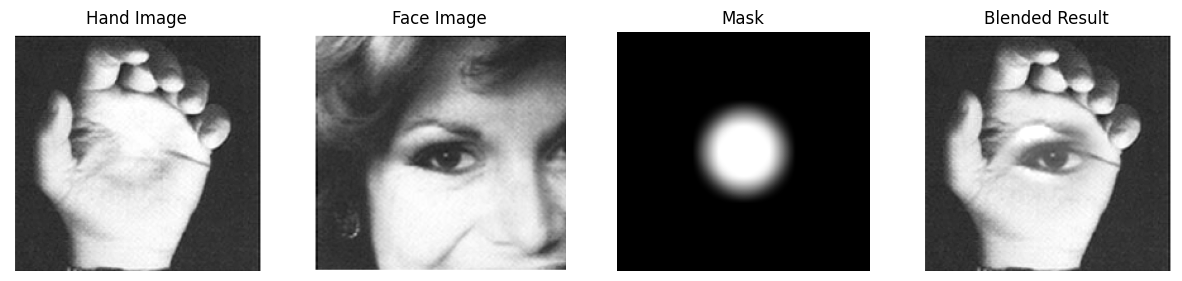

In [36]:
# Display results
plt.figure(figsize=(15, 5))

plt.subplot(141)
plt.imshow(hand, cmap='gray')
plt.title('Hand Image')
plt.axis('off')
    
plt.subplot(142)
plt.imshow(face, cmap='gray')
plt.title('Face Image')
plt.axis('off')
    
plt.subplot(143)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
    
plt.subplot(144)
plt.imshow(result, cmap='gray')
plt.title('Blended Result')
plt.axis('off')
    
plt.show()